In [1]:
# CLAM

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torch
import torch.nn as nn

# 1) Download and merge multiple tickers with technical indicators
def load_ticker_windows(ticker, seq_len=30):
    file_path = f"{ticker}_daily_2018-2025.csv"

    if not os.path.exists(file_path):
        print(f"Downloading {ticker} data...")
        df = yf.download(
            ticker,
            start="2018-01-01",
            end="2025-06-30",
            interval="1d",
            auto_adjust=True)
        df.to_csv(file_path)
    else:
        print(f"Loading cached {ticker} data from {file_path}")
        df = pd.read_csv(file_path, index_col=0)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)
    df['Close'] = df['Close'].astype(float)
    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True)

    future_ret = df['log_ret'].rolling(5).sum().shift(-5)
    df['target'] = (future_ret > 0).astype(int)
    directions = df['target'].values
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'BB_UP', 'BB_DOWN', 'ATR']

    mats, y, dates = [], [], []
    for i in range(seq_len, len(df)):
        mat = df.iloc[i-seq_len:i][features].values
        norm = (mat - mat.mean(axis=0)) / mat.std(axis=0)
        mats.append(norm.T)
        y.append(directions[i])
        dates.append(df.index[i])
    return np.stack(mats), np.array(y), df.iloc[seq_len:].reset_index()

X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_windows(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True)

# 2) Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

# 3) Dataset and DataLoader
class ChartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

class_counts = np.bincount(y_train)
weights = 1. / class_counts
sample_weights = weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(ChartDataset(X_train, y_train), batch_size=64, sampler=sampler)
val_loader   = DataLoader(ChartDataset(X_val, y_val), batch_size=64)
test_loader  = DataLoader(ChartDataset(X_test, y_test), batch_size=64)

# 4) Model definition
class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Linear(dim, 1)
    def forward(self, H):
        w = torch.softmax(self.attn(H).squeeze(-1), dim=1)
        return torch.bmm(w.unsqueeze(1), H).squeeze(1)

class CNN_LSTM_Attn(nn.Module):
    def __init__(self, seq_len=30, in_channels=10, cnn_dims=[32,64], lstm_hidden=128):
        super().__init__()
        layers = []
        ch = in_channels
        for c in cnn_dims:
            layers += [nn.Conv1d(ch, c, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool1d(2)]
            ch = c
        self.cnn = nn.Sequential(*layers)

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, seq_len)
            cnn_out = self.cnn(dummy)
            lstm_input_dim = cnn_out.shape[1]

        self.lstm = nn.LSTM(
            input_size=lstm_input_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.attn = Attention(lstm_hidden * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc   = nn.Linear(lstm_hidden * 2, 2)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        H, _ = self.lstm(x)
        c = self.attn(H)
        return self.fc(self.dropout(c))

# 5) Train & Eval setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM_Attn().to(device)

class_wts = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_wts, dtype=torch.float32).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

def smooth_labels(y, smoothing=0.1):
    y_onehot = torch.zeros((y.size(0), 2)).to(y.device)
    y_onehot.scatter_(1, y.unsqueeze(1), 1)
    y_smooth = y_onehot * (1 - smoothing) + (smoothing / 2)
    return y_smooth

def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    total_loss, correct, total = 0, 0, 0
    all_pred, all_true = [], []
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        if train: optimizer.zero_grad()
        logits = model(Xb)
        if train:
            targets = smooth_labels(yb, 0.1)
            probs = torch.log_softmax(logits, dim=1)
            loss = torch.nn.KLDivLoss(reduction='batchmean')(probs, targets)
        else:
            loss = criterion(logits, yb)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * Xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += Xb.size(0)
        all_pred.extend(preds.cpu().numpy())
        all_true.extend(yb.cpu().numpy())
    return total_loss / total, correct / total, all_true, all_pred

# 6) Training loop (controlled by flag)
DO_TRAINING = True
if DO_TRAINING:
    best, wait = float('inf'), 0
    PATIENCE = 20
    for ep in range(1, 100):
        tr_l, tr_a, _, _ = run_epoch(train_loader, train=True)
        v_l, v_a, _, _ = run_epoch(val_loader, train=False)
        scheduler.step(v_l)
        print(f"Epoch {ep:02d} — Train loss {tr_l:.4f}, acc {tr_a:.3f}; Val loss {v_l:.4f}, acc {v_a:.3f}")
        if v_l < best:
            torch.save(model.state_dict(), 'best_cls.pth')
            best, wait = v_l, 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print("Early stopping")
                break
else:
    print("\n========== Skipping training phase. ==========\n")

# 7) Evaluation
model.load_state_dict(torch.load('best_cls.pth'))
t_l, t_a, y_true, y_pred = run_epoch(test_loader, train=False)
print(f"Test loss {t_l:.4f}, Test acc {t_a:.3f}")

for name, y in zip(["Train", "Val", "Test"], [y_train, y_val, y_test]):
    counts = np.bincount(y)
    print(f"{name} - Up: {counts[1]/sum(counts):.2f}, Down: {counts[0]/sum(counts):.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Down', 'Up']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


Epoch 01 — Train loss 0.4946, acc 0.507; Val loss 0.6923, acc 0.575
Epoch 02 — Train loss 0.4920, acc 0.526; Val loss 0.6931, acc 0.580
Epoch 03 — Train loss 0.4826, acc 0.573; Val loss 0.7011, acc 0.455
Epoch 04 — Train loss 0.4673, acc 0.610; Val loss 0.6760, acc 0.579
Epoch 05 — Train loss 0.4518, acc 0.630; Val loss 0.6742, acc 0.614
Epoch 06 — Train loss 0.4430, acc 0.644; Val loss 0.6681, acc 0.592
Epoch 07 — Train loss 0.4298, acc 0.662; Val loss 0.6474, acc 0.639
Epoch 08 — Train loss 0.4011, acc 0.701; Val loss 0.6906, acc 0.604
Epoch 09 — Train loss 0.3951, acc 0.705; Val loss 0.6566, acc 0.651
Epoch 10 — Train loss 0.3748, acc 0.724; Val loss 0.6500, acc 0.654
Epoch 11 — Train loss 0.3570, acc 0.746; Val loss 0.6553, acc 0.620
Epoch 12 — Train loss 0.3245, acc 0.780; Val loss 0.6356, acc 0.676
Epoch 13 — Train loss 0.3028, acc 0.792; Val loss 0.6371, acc 0.695
Epoch 14 — Train loss 0.2869, acc 0.811; Val loss 0.6415, acc 0.694
Epoch 15 — Train loss 0.2846, acc 0.812; Val los

=== Classification Report ===
              precision    recall  f1-score   support

        Down       0.82      0.64      0.72       396
          Up       0.77      0.89      0.82       521

    accuracy                           0.78       917
   macro avg       0.79      0.77      0.77       917
weighted avg       0.79      0.78      0.78       917

=== Confusion Matrix ===
[[254 142]
 [ 56 465]]
=== Baseline: Buy-and-Hold Stock Performance ===
Starting capital:     $ 1,000.00
Ending capital:       $ 2,279.74
Total $ growth:       $ 1,279.74
Percentage growth:    127.97%


=== Profitability by Confidence Threshold ===

Threshold: 0.50 | Final: $821.68 | Net P/L: $-178.32 | Trades: 607 | Avg Gain: 0.0180 | Avg Loss: -0.0192
Threshold: 0.60 | Final: $773.98 | Net P/L: $-226.02 | Trades: 459 | Avg Gain: 0.0180 | Avg Loss: -0.0200
Threshold: 0.70 | Final: $917.90 | Net P/L: $-82.10 | Trades: 296 | Avg Gain: 0.0180 | Avg Loss: -0.0184
Threshold: 0.80 | Final: $1,106.77 | Net P/L: $106.

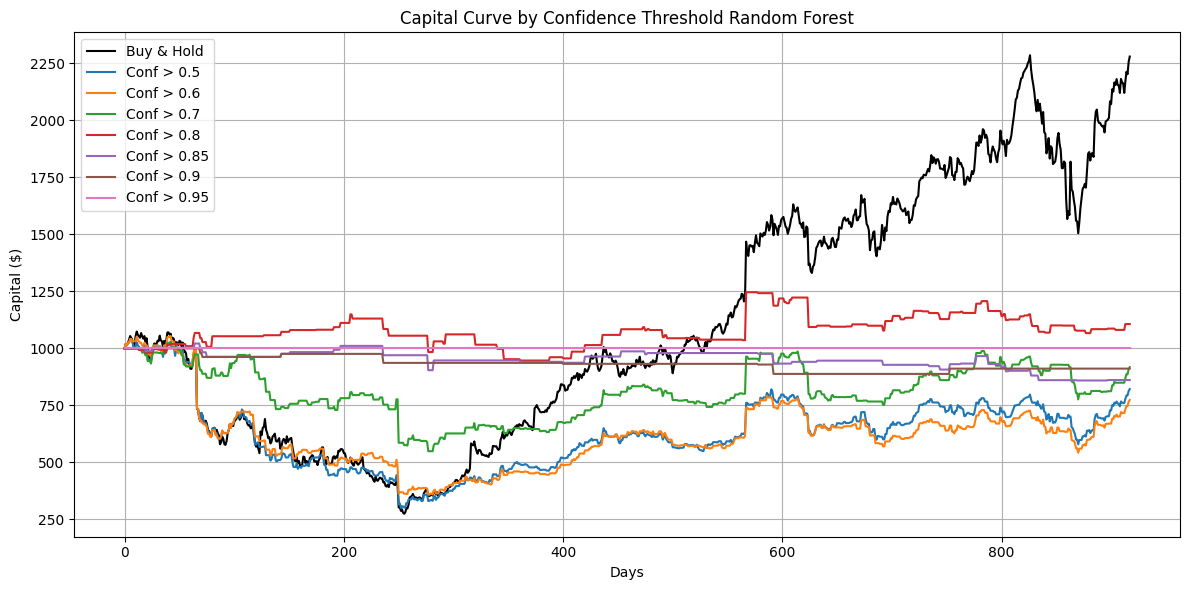

In [5]:
# Decision Tree

import yfinance as yf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1) Load ticker data
def load_ticker_windows(ticker, seq_len=30):
    file_path = f"{ticker}_daily_2018-2025.csv"
    if not os.path.exists(file_path):
        df = yf.download(ticker, start="2018-01-01", end="2025-06-30", interval="1d", auto_adjust=True)
        df.to_csv(file_path)
    else:
        df = pd.read_csv(file_path, index_col=0)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True)

    future_ret = df['log_ret'].rolling(5).sum().shift(-5)
    df['target'] = (future_ret > 0).astype(int)

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'BB_UP', 'BB_DOWN', 'ATR']
    mats, y, dates = [], [], []

    for i in range(seq_len, len(df)):
        mat = df.iloc[i-seq_len:i][features].values
        # No normalization here, just flatten
        mats.append(mat.T.flatten())
        y.append(df['target'].iloc[i])
        dates.append(df.index[i])

    return np.stack(mats), np.array(y), df.iloc[seq_len:].reset_index()

# 2) Load all tickers
X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_windows(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True)

# 3) Train-test split (with shuffle)
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

# 4) Train Random Forest without normalization
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 5) Evaluate
y_pred = rf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))



# 6) Capital simulation across thresholds
probs = rf.predict_proba(X_test)
confidences = np.max(probs, axis=1)
y_pred_conf = np.argmax(probs, axis=1)

returns = np.exp(df_all['log_ret'].values) - 1
test_returns = returns[-len(y_pred_conf):]
initial_capital = 1000.0


# Stock performance over the test period (baseline: buy-and-hold)
stock_capital = initial_capital
stock_curve = [stock_capital]

for ret in test_returns:
    stock_capital *= (1 + ret)
    stock_curve.append(stock_capital)

stock_growth = stock_capital - initial_capital
stock_pct_growth = (stock_capital / initial_capital - 1) * 100

print("=== Baseline: Buy-and-Hold Stock Performance ===")
print(f"Starting capital:     $ {initial_capital:,.2f}")
print(f"Ending capital:       $ {stock_capital:,.2f}")
print(f"Total $ growth:       $ {stock_growth:,.2f}")
print(f"Percentage growth:    {stock_pct_growth:.2f}%\n")

plt.figure(figsize=(12, 6))
plt.plot(stock_curve, label="Buy & Hold", linestyle="-", color="black")

thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
results = []

for thresh in thresholds:
    capital = initial_capital
    capital_curve = [capital]
    trade_count = 0
    profit_trades, loss_trades = [], []

    for ret, pred, conf in zip(test_returns, y_pred_conf, confidences):
        if pred == 1 and conf > thresh:
            trade_count += 1
            capital *= (1 + ret)
            (profit_trades if ret >= 0 else loss_trades).append(ret)
        capital_curve.append(capital)

    results.append({
        'threshold': thresh,
        'final_capital': capital,
        'net_PL': capital - initial_capital,
        'total_trades': trade_count,
        'avg_gain': np.mean(profit_trades) if profit_trades else 0,
        'avg_loss': np.mean(loss_trades) if loss_trades else 0,
    })

    plt.plot(capital_curve, label=f"Conf > {thresh}")

# 7) Summary print
print("\n=== Profitability by Confidence Threshold ===\n")
for r in results:
    print(f"Threshold: {r['threshold']:.2f} | Final: ${r['final_capital']:,.2f} | "
          f"Net P/L: ${r['net_PL']:,.2f} | Trades: {r['total_trades']} | "
          f"Avg Gain: {r['avg_gain']:.4f} | Avg Loss: {r['avg_loss']:.4f}")

# 8) Plot
plt.title("Capital Curve by Confidence Threshold Random Forest")
plt.xlabel("Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


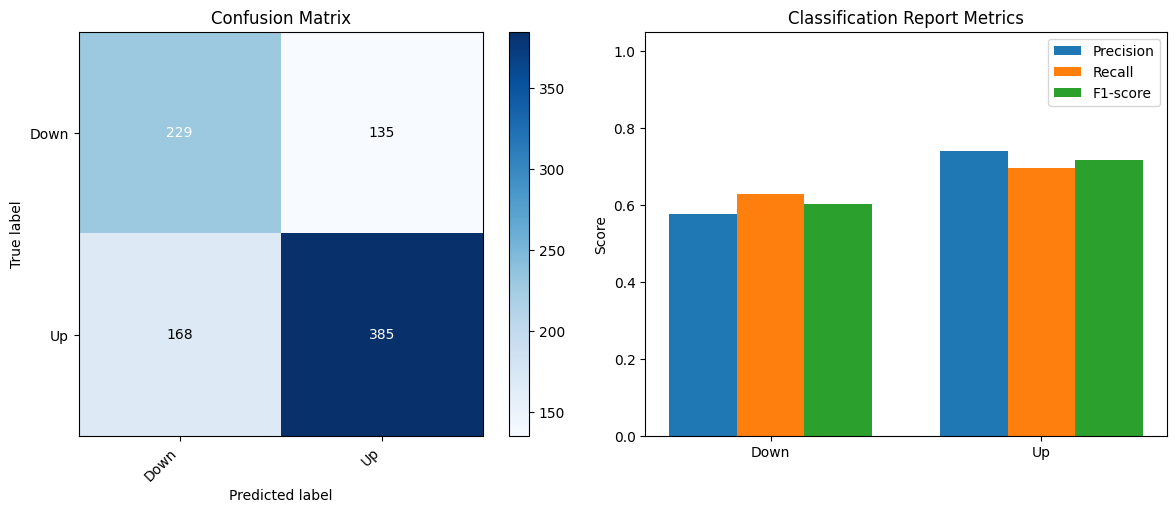

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# … after you’ve computed y_true, y_pred …

# 1) Compute metrics
cr_dict = classification_report(
    y_true, y_pred,
    target_names=['Down', 'Up'],
    output_dict=True
)
labels = ['Down', 'Up']
precision = [cr_dict[l]['precision'] for l in labels]
recall    = [cr_dict[l]['recall']    for l in labels]
f1        = [cr_dict[l]['f1-score']  for l in labels]

# 2) Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3) Make 1×2 subplot
fig, (ax_cm, ax_bar) = plt.subplots(1, 2, figsize=(12, 5))

# —— A) Confusion matrix heatmap ——
im = ax_cm.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(im, ax=ax_cm)
ax_cm.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)
plt.setp(ax_cm.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax_cm.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

# —— B) Classification‐report bar chart ——
x = np.arange(len(labels))
width = 0.25

ax_bar.bar(x - width, precision, width, label='Precision')
ax_bar.bar(x,        recall,    width, label='Recall')
ax_bar.bar(x + width, f1,       width, label='F1-score')

ax_bar.set(
    xticks=x,
    xticklabels=labels,
    ylabel='Score',
    title='Classification Report Metrics'
)
ax_bar.legend(loc='best')
ax_bar.set_ylim(0, 1.05)  # since these are proportions

fig.tight_layout()
plt.show()


=== Baseline: Buy-and-Hold Stock Performance ===
Starting capital:     $ 1,000,000.00
Ending capital:       $ 2,279,737.72
Total 1,279,737.72
Percentage growth:    127.97%

Confidence threshold: 0.5
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,698,491.13
Net P/L:          $ 698,491.13

Confidence threshold: 0.6
Starting capital: $ 1,000,000.00
Ending capital:   $ 950,958.16
Net P/L:          $ -49,041.84

Confidence threshold: 0.7
Starting capital: $ 1,000,000.00
Ending capital:   $ 871,127.07
Net P/L:          $ -128,872.93

Confidence threshold: 0.8
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,363,613.33
Net P/L:          $ 363,613.33

Confidence threshold: 0.9
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,295,763.51
Net P/L:          $ 295,763.51

Confidence threshold: 0.95
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,074,856.75
Net P/L:          $ 74,856.75



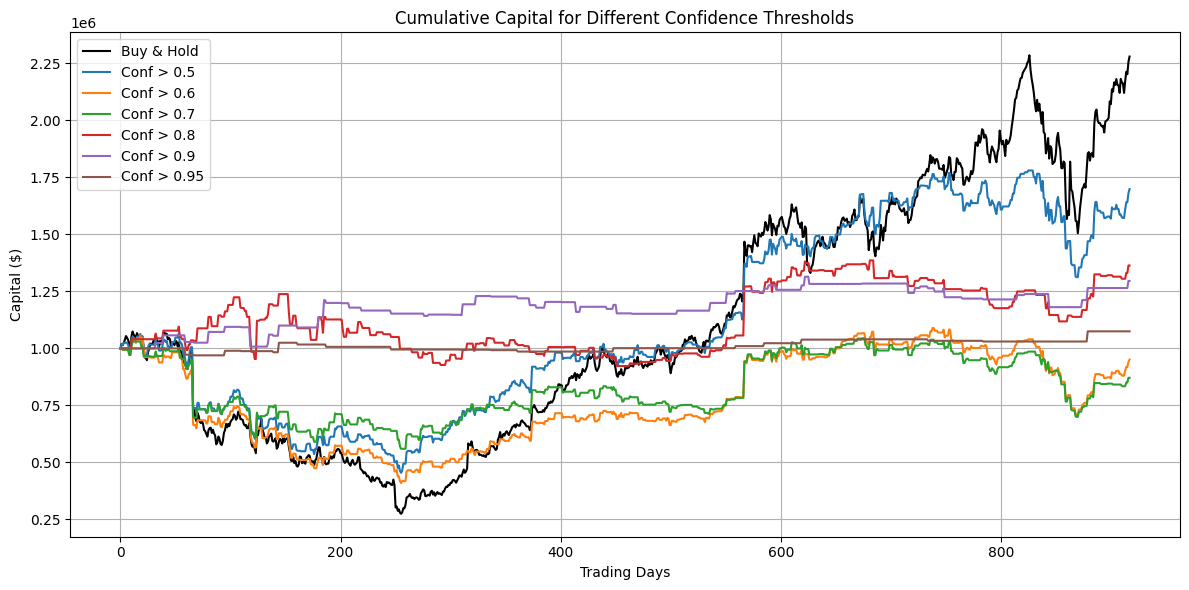

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import torch

initial_capital = 1_000_000.0

# Assuming model, device, test_loader, df_all, and y_test are already defined as in your code
# Calculate softmax probabilities once
all_logits = []
model.eval()
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        all_logits.append(logits.cpu())
logits_all = torch.cat(all_logits, dim=0)
probs = torch.softmax(logits_all, dim=1)
confidences, y_pred_conf = probs.max(dim=1)

returns = np.exp(df_all['log_ret'].values) - 1
test_returns = returns[-len(y_pred_conf):]

# Define multiple confidence thresholds
confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

plt.figure(figsize=(12, 6))

# Stock performance over the test period (baseline: buy-and-hold)
stock_capital = initial_capital
stock_curve = [stock_capital]

for ret in test_returns:
    stock_capital *= (1 + ret)
    stock_curve.append(stock_capital)

stock_growth = stock_capital - initial_capital
stock_pct_growth = (stock_capital / initial_capital - 1) * 100

print("=== Baseline: Buy-and-Hold Stock Performance ===")
print(f"Starting capital:     $ {initial_capital:,.2f}")
print(f"Ending capital:       $ {stock_capital:,.2f}")
print(f"Total {stock_growth:,.2f}")
print(f"Percentage growth:    {stock_pct_growth:.2f}%\n")

plt.plot(stock_curve, label="Buy & Hold", color="black")


for CONF_THRESH in confidence_thresholds:
    capital = initial_capital
    capital_curve = [capital]

    for ret, pred, conf in zip(test_returns, y_pred_conf, confidences):
        if pred == 1 and conf > CONF_THRESH:
            capital *= (1 + ret)
        capital_curve.append(capital)

    print(f"Confidence threshold: {CONF_THRESH}")
    print(f"Starting capital: $ {initial_capital:,.2f}")
    print(f"Ending capital:   $ {capital:,.2f}")
    print(f"Net P/L:          $ {capital - initial_capital:,.2f}\n")

    plt.plot(capital_curve, label=f"Conf > {CONF_THRESH}")

plt.title("Cumulative Capital for Different Confidence Thresholds")
plt.xlabel("Trading Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

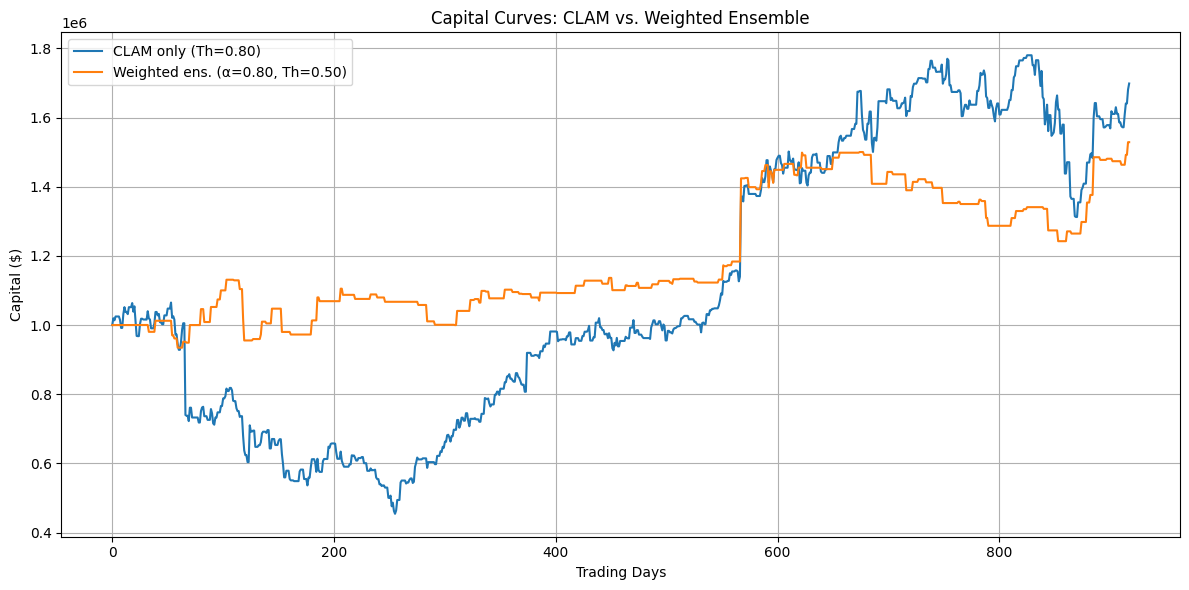

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# assume test_returns, preds_dt, confs_dt, preds_cla, confs_cla are defined

def backtest_ensemble(test_returns, preds_dt, confs_dt, preds_cla, confs_cla,
                      threshold, initial_capital=1e6):
    use_cla       = confs_cla > threshold
    ensemble_pred = np.where(use_cla, preds_cla, preds_dt)
    ret_masked    = np.where(ensemble_pred == 1, test_returns, 0.0)
    curve         = np.concatenate((
        [initial_capital],
        initial_capital * np.cumprod(1 + ret_masked)
    ))
    return curve

# 1) pure CLAM with threshold 0.0
cla_curve = backtest_ensemble(
    test_returns, preds_dt, confs_dt, preds_cla, confs_cla,
    threshold=0.50
)

# 2) weighted-avg ensemble (α=0.8)
alpha = 0.8
combined_probs  = alpha * probs_cla + (1-alpha) * probs_dt
preds_combined  = np.argmax(combined_probs, axis=1)
confs_combined  = np.max(combined_probs, axis=1)

weighted_curve = backtest_ensemble(
    test_returns,
    preds_dt=np.zeros_like(preds_dt),    # unused
    confs_dt=np.zeros_like(confs_dt),    # unused
    preds_cla=preds_combined,
    confs_cla=confs_combined,
    threshold=0.8
)

# Single plot
plt.figure(figsize=(12,6))
plt.plot(cla_curve,     label="CLAM only (Th=0.80)")
plt.plot(weighted_curve, label=f"Weighted ens. (α={alpha:.2f}, Th=0.50)")
plt.title("Capital Curves: CLAM vs. Weighted Ensemble")
plt.xlabel("Trading Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
